In [ ]:
import sys
sys.path.append('../Scapade')

from fitbert import FitBert

from pathlib import Path
from symspellpy_scapade import symspellscapade
import pkg_resources
import pandas as pd
import warnings

from spellchecker import SpellChecker

from pathlib import Path


warnings.simplefilter('ignore')


from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
# Load S-capade method - only need to do this once, this takes the longest time at outset
SymSpell = symspellscapade.SymSpell
Verbosity = symspellscapade.Verbosity
scapade = SymSpell(max_dictionary_edit_distance=2, prefix_length=15)
dictionary_path = pkg_resources.resource_filename("symspellpy_scapade", "cmu_frequency_added.csv")
scapade.load_dictionary(dictionary_path, term_index=1, count_index=2)

def correction(scapade, phoneme_sequence):
    misspelling = phoneme_sequence
    suggestions = scapade.lookup(misspelling, Verbosity.ALL)
    input_path_csv = Path.cwd().parent / "Scapade" / "symspellpy_scapade" / "cmu_frequency_added.csv"
    df = pd.read_csv(input_path_csv, names=['word', 'seq', 'count'])
    correction_dict =  {misspelling:{"suggested_correction":"", "candidates":[]}}

    for suggestion in suggestions:
        if len(correction_dict[misspelling]['candidates']) >= 10:
            break
        current_seq = str(suggestion).split(',')[0]
        df_slice = df[df['seq'] == current_seq].sort_values(by=['count'], ascending=False)
        if correction_dict[misspelling]['suggested_correction'] == '' and df_slice.iloc[0]['count'] >= 1:
            correction_dict[misspelling]['suggested_correction'] = df_slice.iloc[0]['word']
        if len(correction_dict[misspelling]['suggested_correction']) > 0 and \
        len(correction_dict[misspelling]['candidates']) <= 10:
            df_slice = df_slice[df_slice['count'] > 1]
            correction_dict[misspelling]['candidates'] += (list(df_slice[:5]['word']))
    return correction_dict

In [3]:
def generate_scapade_candidates(phoneme_seq):
    scapade_candidates = correction(scapade, phoneme_seq)[phoneme_seq]['candidates']
    return scapade_candidates

spell = SpellChecker()
def generate_pyspell_candidates(misspelling):
    pyspell_candidates = spell.candidates(misspelling)
    return list(pyspell_candidates)

In [4]:
# Initializing FitBert is a bit slow, so this makes sure it's only done once
if "fb" not in globals():
    fb = FitBert()
    
    
def rank_candidates(row, candidates_col_name, masked_string_col_name):
    """ 
    Use FitBert to rank a list of candidates in a given context
    
    Assumed to be used with the df.apply() method
    
    Args:
    row: a row in a DataFrame
    candidates_col_name: the name of the column containing a list of candidates
    masked_string_col_name: the name of the column containing the context
    
    Returns a list of candidates sorted by ranking (best ranked first)
    
    """
    candidates = row[candidates_col_name]
    masked_string = row[masked_string_col_name]
    
    ranked_options = fb.rank(masked_string, options=candidates, delemmatize=False)
    
    return ranked_options

device: cpu
using model: bert-large-uncased


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The input csv (at `csv_path`), should have the format as below, with the same column names.
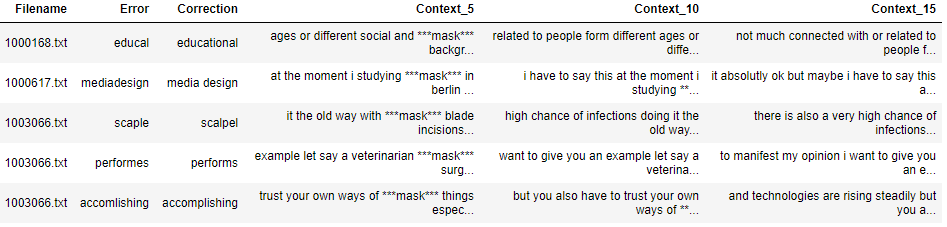


The txt file at `phoneme_path` should have the following format, as output by g2p-seq2seq.

|  |
| ---  |
| educal EH JH AH K AH L |
| mediadesign M IY D IY AH D EH Z IH G N |
| scaple S K EY P AH L |
| performes P ER F AO R M Z |
| accomlishing AH K AA M L IH SH IH NG |

In [17]:
language_code = "ARA" 
file_path = Path.cwd().parent / "Data" / language_code

csv_file_name = f"{language_code}_errors_clean.csv"
errors_file_name = f"{language_code}_errors_only.csv"
phoneme_file_name = f"{language_code}_phonemes.txt"

errors = pd.read_csv(file_path / csv_file_name)["Error"]
errors.to_csv(file_path / errors_file_name, index=False, header=False)
print(file_path / errors_file_name)

# edit this path to where the model rests in your file structure
model_path="/mnt/c/Users/Conor/My Documents/S-capade Research/Scapade/g2p_files/g2p-seq2seq-model-6.2-cmudict-nostress"

!g2p-seq2seq --decode "{file_path / errors_file_name}" --model_dir "{model_path}" --output "{file_path / phoneme_file_name}"


/mnt/c/Users/Conor/Documents/scapade-non-native-analytics/Conor/Data/ARA/ARA_errors_only.csv




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




INFO:tensorflow:Importing user module g2p_seq2seq from path /home/conor/miniconda3/envs/seq-bert/lib/python3.7/site-packages/g2p_seq2seq-6.2.2a0-py3.7.egg

INFO:tensorflow:Overriding hparams in transformer_base with num_hidden_layers=3,num_heads=4,batch_size=4096,length_bucket_step=1.5,filter_size=512,max_length=30,eval_drop_long_sequences=1,hidden_size=256,min_length_bucket=6




Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:schedule=continuous_train_and_e


Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
2021-03-11 15:26:21.753738: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-03-11 15:26:21.834976: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2711995000 Hz
2021-03-11 15:26:21.837210: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e638322270 initialized for platform Host (this does not guarantee that XLA will be used). Devic

2021-03-11 15:26:22.392701: W tensorflow/core/common_runtime/colocation_graph.cc:983] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_device_name_='' resource_device_name_='/device:GPU:0' supported_device_types_=[CPU] possible_devices_=[]
RefEnter: CPU 
Assign: CPU 
IsVariableInitialized: CPU 
RandomUniform: CPU XLA_CPU 
Const: CPU XLA_CPU 
Mul: CPU XLA_CPU 
Sub: CPU XLA_CPU 
Add: CPU XLA_CPU 
Identity: CPU XLA_CPU 
VariableV2: CPU 

Colocation members, user-requested devices, and framework assigned devices, if any:
  transformer

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Decoding batch 1 out of 268
INFO:tensorflow:Decoding batch 2 out of 268
INFO:tensorflow:Decoding batch 3 out of 268

INFO:tensorflow:Decoding batch 4 out of 268
INFO:tensorflow:Decoding batch 5 out of 268
INFO:tensorflow:Decoding batch 6 out of 268
INFO:tensorflow:Decoding batch 7 out of 268
INFO:tensorflow:Decoding batch 8 out of 268
INFO:tensorflow:Decoding batch 9 out of 268
INFO:tensorflow:Decoding batch 10 out of 268
INFO:tensorflow:Decoding batch 11 out of 268
INFO:tensorflow:Decoding batch 12 out of 268
INFO:tensorflow:Decoding batch 13 out of 268
INFO:tensorflow:Decoding batch 14 out of 268
INFO:tensorflow:Decoding batch 15 out of 268
INFO:tensorflow:Decoding batch 16 out of 268
INFO:tensorflow:Decoding batch 17 out of 268
INFO:tensorflow:Decoding batch 18 out of 268
INFO:tensorflow:Decoding batch 19 out of 268
INFO:tensorflow:Decoding batch 20 out of 268
INFO:tensorflow:Decoding 

INFO:tensorflow:Decoding batch 173 out of 268
INFO:tensorflow:Decoding batch 174 out of 268
INFO:tensorflow:Decoding batch 175 out of 268
INFO:tensorflow:Decoding batch 176 out of 268
INFO:tensorflow:Decoding batch 177 out of 268
INFO:tensorflow:Decoding batch 178 out of 268
INFO:tensorflow:Decoding batch 179 out of 268
INFO:tensorflow:Decoding batch 180 out of 268
INFO:tensorflow:Decoding batch 181 out of 268
INFO:tensorflow:Decoding batch 182 out of 268
INFO:tensorflow:Decoding batch 183 out of 268
INFO:tensorflow:Decoding batch 184 out of 268
INFO:tensorflow:Decoding batch 185 out of 268
INFO:tensorflow:Decoding batch 186 out of 268
INFO:tensorflow:Decoding batch 187 out of 268
INFO:tensorflow:Decoding batch 188 out of 268
INFO:tensorflow:Decoding batch 189 out of 268
INFO:tensorflow:Decoding batch 190 out of 268
INFO:tensorflow:Decoding batch 191 out of 268
INFO:tensorflow:Decoding batch 192 out of 268
INFO:tensorflow:Decoding batch 193 out of 268
INFO:tensorflow:Decoding batch 194

In [18]:
errors

0         seriouse
1          cocepts
2         clearily
3         cocnepts
4            breif
           ...    
8545     analizing
8546    concidered
8547    creativety
8548      oblidges
8549    exagerates
Name: Error, Length: 8550, dtype: object

In [19]:
df = pd.read_csv(file_path / csv_file_name)


df = df[["Error","Correction","Context_15"]]
df = df.rename({'Context_15':'Masked Context'}, axis=1)

phonemes_df = pd.read_csv(file_path / phoneme_file_name, header=None)

# Split the phoneme file at the first occurence of a space
df['Phoneme Seq'] = phonemes_df[0].apply(lambda x : x.split(' ', 1)[1])

df

,Error,Correction,Masked Context,Phoneme Seq
0,seriouse,serious,not have broad knowledge of his field of study...,S IH R IY AH S
1,cocepts,concepts,the ideas and concepts before thinking about l...,K OW S EH P T S
2,clearily,clearly,the study with out understanding the student w...,K L IH R AH L IY
3,cocnepts,concepts,it is more important for students to understan...,K AA K N EH P T S
4,breif,brief,learn the facts easily after understanding it ...,B R IY F
...,...,...,...,...
8545,analizing,analyzing,fact when students understand ideas they becom...,AE N AH L AY Z IH NG
8546,concidered,considered,that there has to be a base for everything som...,K AH N S IH D ER D
8547,creativety,creativity,ideas they become more productive and more acc...,K R IY EY T IH V T IY
8548,oblidges,obliges,a book or a biography an idea has to be studie...,AH B L IH JH IH Z


<b>The following two cells may take several hours to run  if the dataset is large.</b>

In [20]:
print('Getting S-Capade Candidates...')

# progress_apply() is the same as apply(), but shows a nice progress bar.
df['S-Capade Candidates'] = df['Phoneme Seq'].progress_apply(generate_scapade_candidates)

print('Done.')

print('Getting PySpell Candidates...')
df['PySpell Candidates'] =  df['Error'].progress_apply(generate_pyspell_candidates)
print('Done.')

print('Getting combined Candidates...')
df['Combined Candidates'] =  df.progress_apply(lambda x : list(set(x['S-Capade Candidates']) | set(x['PySpell Candidates'])),
                                               axis=1)
print('Done.')

Getting S-Capade Candidates...


  0%|          | 0/8550 [00:00<?, ?it/s]

Done.
Getting PySpell Candidates...


  0%|          | 0/8550 [00:00<?, ?it/s]

Done.
Getting combined Candidates...


  0%|          | 0/8550 [00:00<?, ?it/s]

Done.


In [21]:
print('Ranking S-Capade Candidates...')
df['S-Capade Ranked'] = df.progress_apply(rank_candidates, args=('S-Capade Candidates', 'Masked Context'),
                                               axis=1)
print('Done.')

print('Ranking PySpell Candidates...')
df['PySpell Ranked'] =  df.progress_apply(rank_candidates, args=('PySpell Candidates', 'Masked Context'),
                                               axis=1)
print('Done.')

print('Ranking Combined Candidates...')
df['Combined Ranked'] =  df.progress_apply(rank_candidates, args=('Combined Candidates', 'Masked Context'),
                                               axis=1)
print('Done.')

Ranking S-Capade Candidates...


  0%|          | 0/8550 [00:00<?, ?it/s]

Done.
Ranking PySpell Candidates...


  0%|          | 0/8550 [00:00<?, ?it/s]

Done.
Ranking Combined Candidates...


  0%|          | 0/8550 [00:00<?, ?it/s]

Done.


In [22]:
df

,Error,Correction,Masked Context,Phoneme Seq,S-Capade Candidates,PySpell Candidates,Combined Candidates,S-Capade Ranked,PySpell Ranked,Combined Ranked
0,seriouse,serious,not have broad knowledge of his field of study...,S IH R IY AH S,"[serious, serial, cereal, syrian, series, cere...",[serious],"[serial, serious, cheerios, cetus, series, syr...","[serious, series, syrian, syria, serial, cetus...",[serious],"[serious, series, syrian, syria, serial, cetus..."
1,cocepts,concepts,the ideas and concepts before thinking about l...,K OW S EH P T S,"[accepts, cassettes, concepts, closeups, conce...",[concepts],"[excerpts, cassettes, coasts, accepts, closeup...","[concepts, accepts, excerpts, accents, coasts,...",[concepts],"[concepts, accepts, excerpts, accents, coasts,..."
2,clearily,clearly,the study with out understanding the student w...,K L IH R AH L IY,"[clearly, clarity, clearance, crazily, crucial...",[clearly],"[crucially, clearance, carefully, clearly, cle...","[clearly, carefully, clearcut, literally, cruc...",[clearly],"[clearly, carefully, clearcut, literally, cruc..."
3,cocnepts,concepts,it is more important for students to understan...,K AA K N EH P T S,"[concepts, convents, contests, contents]",[concepts],"[contests, convents, concepts, contents]","[concepts, contents, contests, convents]",[concepts],"[concepts, contents, contests, convents]"
4,breif,brief,learn the facts easily after understanding it ...,B R IY F,"[brief, grief, breach, breech, bream, breeze, ...",[brief],"[breach, breech, brief, grief, beep, breeze, b...","[brief, bream, breeze, breathe, beep, breech, ...",[brief],"[brief, bream, breeze, breathe, beep, breech, ..."
...,...,...,...,...,...,...,...,...,...,...
8545,analizing,analyzing,fact when students understand ideas they becom...,AE N AH L AY Z IH NG,"[analyses, tantalizing, idolizing, agonizing, ...",[analyzing],"[idolizing, fantasizing, analyzing, tantalizin...","[realizing, analyses, finalizing, agonizing, t...",[analyzing],"[analyzing, realizing, analyses, finalizing, a..."
8546,concidered,considered,that there has to be a base for everything som...,K AH N S IH D ER D,"[considered, considers, considerate, conceded,...",[considered],"[considerate, concerted, considered, considers...","[considered, conspired, considerate, consider,...",[considered],"[considered, conspired, considerate, consider,..."
8547,creativety,creativity,ideas they become more productive and more acc...,K R IY EY T IH V T IY,"[creatively, creativity, creative]","[creatively, creativity]","[creative, creatively, creativity]","[creativity, creatively, creative]","[creativity, creatively]","[creativity, creatively, creative]"
8548,oblidges,obliges,a book or a biography an idea has to be studie...,AH B L IH JH IH Z,"[obliges, bridges, obliging, abridging, colleg...",[obliges],"[abridging, abolishes, obliges, bridges, villa...","[publishes, alleges, bridges, colleges, bulges...",[obliges],"[publishes, alleges, bridges, colleges, bulges..."


In [23]:

output_file_name = f"{language_code}_errors_with_candidates.csv"

df.to_csv(file_path / output_file_name, index=False)